# SIMULATOR AND SUMMARY STATISTICS

In [1]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Load the minimum required library to run the functions
from Utils_functions import *
from numpy.random import uniform, randint
from numpy import array, int64, where, concatenate, linspace, median, sum, log, zeros, mean, var, min, max, einsum
from scipy.integrate import cumulative_trapezoid
from scipy.signal import welch
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 1 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
n_sim = int(2e3)
t_corr = TotalT/50

In [4]:
time_steps_amount = int64(TotalT/dt) # Number of steps
sampled_point_amount = int64(TotalT/DeltaT) # Number of sampled points
sampling_delta_time_steps = int64(DeltaT/dt) # Number of steps between samples
t = linspace(0., TotalT,sampled_point_amount) # Time array

Chose the time characteristics of the input signal (total time, sample rate, numbero of simulations) and transform them into points info

In [5]:
# Limits for the parameters
prior_limits = [[1.5e4, 4e4], 
                [1e4, 140e4], 
                [3e-3, 16e-3], 
                [1.5e-2, 30e-2], 
                [1e-3, 6e-3], 
                [2e-2, 20e-2], 
                [0.5, 6], 
                [5.5, 15.5], 
                [1, 530]]

In [6]:
# Get the theta values from the prior in the different shapes
theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, n_sim)

In [7]:
# Dummy call to force compilation
theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, 1)
Simulator_noGPU(0.1,0.1,1,1,theta);

/home/toxin21/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'theta' of function 'Simulator_noGPU'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "Utils_functions.py", line 33:
@jit(nopython = True)
def Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta, i_state = None): # Cambiare type of theta to a Dictionary
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [8]:
%%time
theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, n_sim)
x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)

CPU times: user 4min 6s, sys: 436 ms, total: 4min 6s
Wall time: 4min 6s


In [9]:
indexes = np.unique(randint(0,x_trace.shape[0], 30))
reduced_trace = x_trace[indexes]
red_f_trace = f_trace[indexes]
Cxx = get_summary_statistics(["Cxx"], reduced_trace, red_f_trace, theta, DeltaT, 11, t, t_corr)
Sred = get_summary_statistics(["s_redx"], reduced_trace, red_f_trace, theta, DeltaT, 11, t, t_corr)
pow_spectra_dx = get_summary_statistics(["psdx"], reduced_trace, red_f_trace, theta, DeltaT, 1000, t, t_corr)
Sample_frequency = 1/DeltaT
sampled_point_amount = x_trace.shape[1]
frequencies, power_spectra = welch(reduced_trace, fs=Sample_frequency, nperseg=1000, axis=1)

In [11]:
n_reduced = reduced_trace.shape[0]
colors = sns.color_palette("deep",n_colors=n_reduced)
means = np.zeros((n_reduced,1))
stds = np.zeros((n_reduced,1))
hermites_0 = np.zeros((n_reduced,1))
hermites_2 = np.zeros((n_reduced,1))
hermites_4 = np.zeros((n_reduced,1))

for i in range(2,reduced_trace.shape[1]):
    means = np.column_stack((means, np.mean(reduced_trace[:,1:i],axis=1)))
    stds = np.column_stack((stds, np.std(reduced_trace[:,:i],axis=1)))
    hermites_0 = np.column_stack((hermites_0, hermite(reduced_trace[:,:i],[1])))
    hermites_2 = np.column_stack((hermites_2, hermite(reduced_trace[:,:i],[0,0,1])))
    hermites_4 = np.column_stack((hermites_4, hermite(reduced_trace[:,:i],[0,0,0,0,1])))

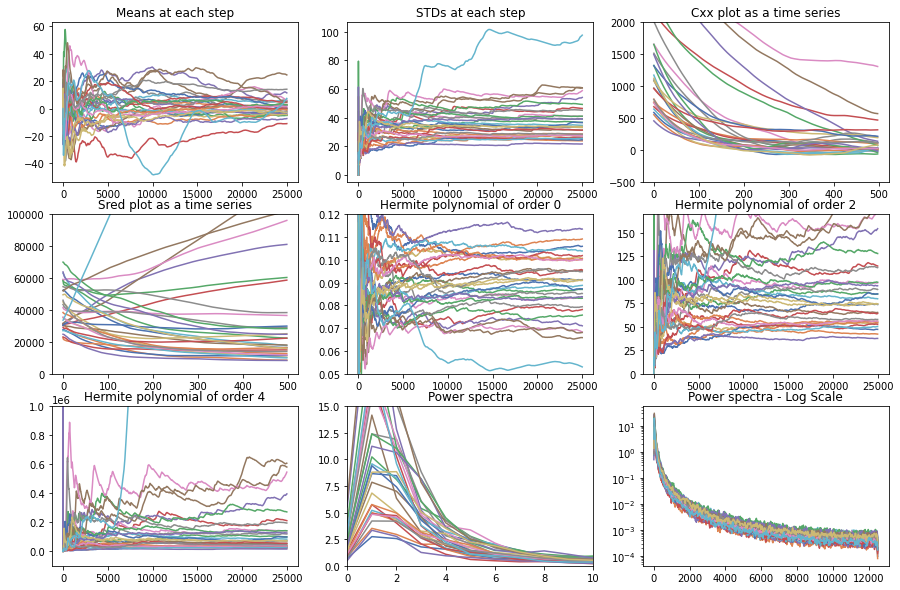

In [23]:
i=0
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(15,10))
ax1.set_title("Means at each step")
ax2.set_title("STDs at each step")
ax3.set_title("Cxx plot as a time series")
ax4.set_title("Sred plot as a time series")
ax5.set_title("Hermite polynomial of order 0")
ax6.set_title("Hermite polynomial of order 2")
ax7.set_title("Hermite polynomial of order 4")
ax8.set_title("Power spectra")
ax9.set_title("Power spectra - Log Scale")
for mean, std, cxx, sred, h0, h2, h4, psdx in zip(means, stds, Cxx, Sred,hermites_0,hermites_2,hermites_4,power_spectra):
    ax1.plot(mean,color=colors[i])
    ax2.plot(std,color=colors[i])
    ax3.plot(cxx,color=colors[i])
    ax4.plot(sred,color=colors[i])
    ax5.plot(h0,color=colors[i])
    ax6.plot(h2,color=colors[i])
    ax7.plot(h4,color=colors[i])
    ax8.plot(psdx,color=colors[i])
    ax9.semilogy(frequencies, psdx,color=colors[i])
    i+=1
ax3.set_ylim(-300,2000)
ax4.set_ylim(0,100000)
ax5.set_ylim(0.05,0.12)
ax6.set_ylim(0,170)
ax7.set_ylim(-1e5,1e6)
ax8.set_ylim(0,15)
ax8.set_xlim(0,10)


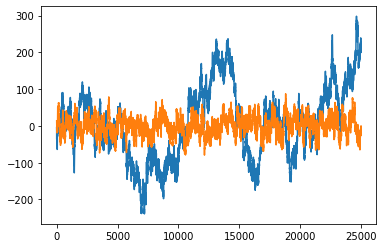

In [35]:
plt.plot(reduced_trace[-0+np.argmax(stds[:,-1])])
plt.plot(reduced_trace[-10+np.argmax(stds[:,-1])])

In [9]:
# import _pickle as pickle
# with open('data/x_trace.pkl', 'wb') as f:
#     pickle.dump(x_trace, f)
    
# with open('data/f_trace.pkl', 'wb') as f:
#     pickle.dump(f_trace, f)

# with open('data/y_trace.pkl', 'wb') as f:
#     pickle.dump(y_trace, f)
    
# with open("data/theta.pkl", 'wb') as f:
#     pickle.dump(theta, f)

In [10]:
S_mean, Fx, Fy, S_tot = compute_entropy_production(x_trace, y_trace, f_trace, theta, n_sim)

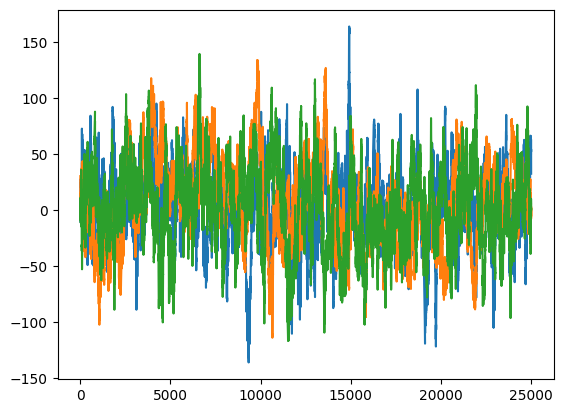

In [11]:
for i in range(3):
    plt.plot(x_trace[i,:])

Simulating the x trajectory and the f trajectory to then obtain the summary statistics, in this case the autocorrellation and the cross correllation in combination with the reduced energy production.

I don't know which formula we can pick to compute the reduce energy production, from autocorrellation, from cross correllation, all together?

ADD: Write a function GET_SUMMARY_STATISTICS() which is a list of functions, each function for a summoner statistic

In [12]:
%%time
list_stat = ["Cxx", "s_redx", "s_redf", "psdx"]
s = get_summary_statistics(list_stat, x_trace, f_trace, theta, DeltaT, 3, t, t_corr)
s.shape

CPU times: user 1min 11s, sys: 10.8 s, total: 1min 21s
Wall time: 1min 21s


torch.Size([2000, 5664])

Maybe we can select different summary statistics and usa some feature selection technique. If we use a lot of summary statistics maybe dimentionality reductions? PCA?
The idea is to use different summary statistics but to then to select the most important features of them deleting the correllations between them.

An example could be the Power spectral density for both x and f.
It can identify if there are any dominant frequencies in your data, or if the power is distributed across a range of frequencies, usefull for oscillatory behaviour

We can use directly the psds as input of the neural network or we can take some statistics about each one, like mean, median, max, min,variance, entropy, frequency of top power. We can think of more statistics

# INFERENCE STATISTICS

In [13]:
from torch import Tensor, Size
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from numpy import squeeze

In [14]:
# Prior distribution for sbi
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)

In [15]:
# Call infer form sbi
infer = SNPE(prior=prior)
inferece = infer.append_simulations(theta_torch, s)

In [16]:
# Train the model
density_estimator = infer.train()
posterior = infer.build_posterior(density_estimator)

 Neural network successfully converged after 25 epochs.

In [17]:
# Simulate the observation(s)
theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, n_sim=1)
x_trace_true, f_trace_true, y_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta_true)

In [18]:
# Sample from the posterior
s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta, DeltaT, 3, t, t_corr)
samples = posterior.sample((int(1e5),), x=s)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [19]:
# Getting the some statistics from each marginal distribution
mean_params = np.array([])
mode_params = np.array([])

for i in range(9):
    # Retrive the samples for the parameter i
    params = samples[:,i].numpy()
    # Compute the mean
    mean_params = np.concatenate((mean_params, [np.mean(params)]))
    # Compute the mode
    hist, bin_edges = np.histogram(params, bins=int(np.sqrt(params.shape[0])))
    max_index = np.argmax(hist)
    mode = (bin_edges[max_index] + bin_edges[max_index+1])/2
    mode_params = np.concatenate((mode_params, [mode]))

mean_params = mean_params.reshape(9, 1, 1)
mode_params = mode_params.reshape(9, 1, 1)

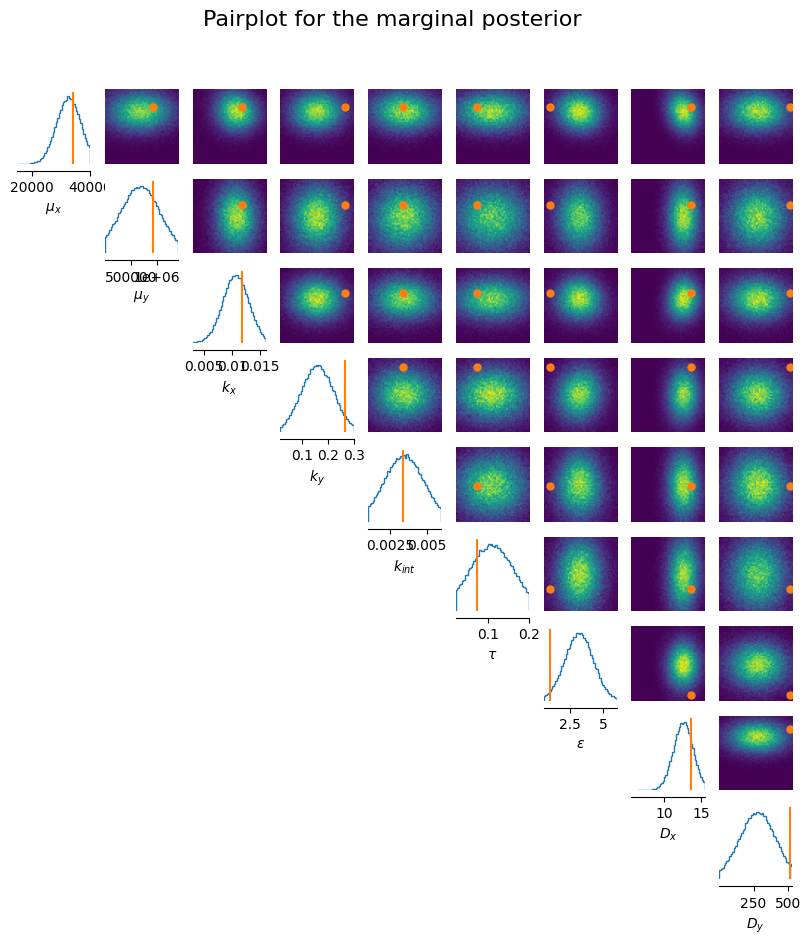

In [20]:
# Pairplot
label_theta = [r"$\mu_x$", r"$\mu_y$", r"$k_x$", r"$k_y$", r"$k_{int}$", r"$\tau$", r"$\varepsilon$", r"$D_x$", r"$D_y$"]
import matplotlib as mpl
_ = analysis.pairplot(samples, points=[theta_torch_true], 
                      limits=prior_limits, figsize=(10, 10), 
                      title = "Pairplot for the marginal posterior",
                      labels=label_theta)

In [21]:
# Compute a new trace using the mode parameters
x_trace_est, f_trace_est, y_trace_est = Simulator_noGPU(dt, DeltaT, TotalT, 1, mode_params)

# ENTROPY PRODUCTION

These are the formulas used to compute the entropy production
$$
S = \sum_{t=0}^{N_{\text{timesteps}}-2} \left( \text{data}_{t+1} - \text{data}_{t} \right) \cdot F\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right) \cdot D^{-1}\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right)
$$
$$
\sigma = \frac{{\mu_y \cdot \varepsilon^2}}{{1 + k_y \cdot \mu_y \cdot \tau - \frac{{k_{int}^2 \cdot \mu_x \cdot \mu_y \cdot \tau^2}}{{1 + k_x \cdot \mu_x \cdot \tau}}}}
$$

In [22]:
sigma_true, _, _, _ = compute_entropy_production(x_trace_true, y_trace_true, f_trace_true, theta_true, 1)
sigma_est, _, _, _ = compute_entropy_production(x_trace_est, y_trace_est, f_trace_est, mean_params, 1)

In [23]:
print(sigma_true, sigma_est)
sigma_true/sigma_est

402.2248121110057 351.6733579958213


1.1437454756404524

In [24]:
sigma_true_2, _, = compute_entropy_2(theta_true, 1)
sigma_est_2_mean, _, = compute_entropy_2(mean_params, 1)
sigma_est_2_mode, _, = compute_entropy_2(mode_params, 1)
print("Estimates for the analytical entropy production:")
print(f"True: %.2f, Mean: %.2f, Mode: %.2f" % (sigma_true_2[0][0], sigma_est_2_mean[0][0], sigma_est_2_mode[0][0]))

Estimates for the analytical entropy production:
True: 46.66, Mean: 582.54, Mode: 545.10


In [25]:
sigma_true_2, sigma_est_2_mode, sigma_est_2_mean

([array([46.66324338])], [array([545.09733687])], [array([582.54483945])])

In [26]:
# Get the statistics of sigma directly out of the samples
sigma_samples = array([])
#sanity_check = array([])

for i in range(samples.shape[0]):
    sample = samples[i,:].numpy().reshape(9,1,1)
    #sanity_check = concatenate((sanity_check, [sample[0][0][0]]))
    sigma = compute_entropy_2(list(sample), 1)[0][0][0]
    sigma_samples = concatenate((sigma_samples, [sigma]))

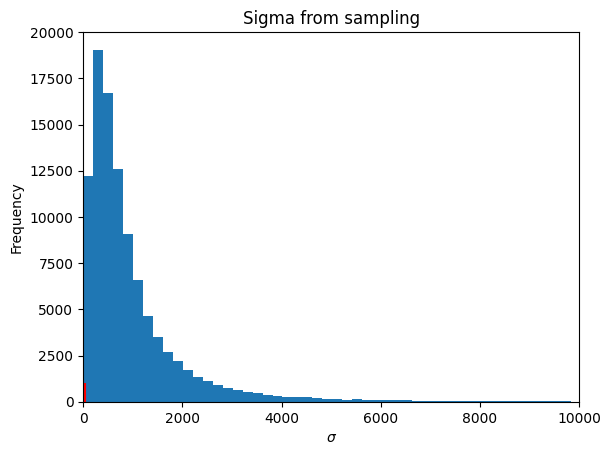

In [28]:
plt.xlim(0, 1e4)
plt.vlines(sigma_true_2, 0, 1e3, color='r')
plt.xlabel(r"$\sigma$")
plt.ylabel("Frequency")
plt.title("Sigma from sampling")
plt.hist(sigma_samples, bins=int(np.sqrt(len(sigma_samples))));

# QUESTIONS
- per calcolare S_red come summary statistics (come fatto da Dresda nel file) usiamo i parametri, non è un bias poi usarla come summary statistics nel neural network durante la SBI?
- qual è la formula corretta per l'entropia? Cosa abbiamo usato noi?
- limiti per la prior distribution sui parametri